<a href="https://colab.research.google.com/github/jrmasiero/similaridade_imagem/blob/main/similaridade_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoImageProcessor, AutoModel
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ========================================
# Configuration
# ========================================
MODEL_CKPT = "google/vit-base-patch16-224-in21k"  # Using a generalist ViT model
BATCH_SIZE = 16
NUM_SAMPLES = 500  # Number of candidate images (from 44,072 total)
SEED = 42
TOP_K = 10  # Number of similar images to retrieve



# 1. Load Model and Processor


In [7]:
print("="*60)
print("FASHION PRODUCT IMAGE SIMILARITY SEARCH")
print("="*60)
print("\n[Step 1/7] Loading Vision Transformer model...")
processor = AutoImageProcessor.from_pretrained(MODEL_CKPT)
model = AutoModel.from_pretrained(MODEL_CKPT)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()
print(f"✓ Model loaded on device: {device}")

FASHION PRODUCT IMAGE SIMILARITY SEARCH

[Step 1/7] Loading Vision Transformer model...


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


✓ Model loaded on device: cpu


# 2. Load Fashion Product Images Dataset

In [8]:
print("\n[Step 2/7] Loading fashion product images dataset...")
print("Dataset: ashraq/fashion-product-images-small")

# Load the complete dataset
dataset = load_dataset("ashraq/fashion-product-images-small")
print(f"✓ Dataset loaded: {len(dataset['train'])} total products")

# Display dataset info
print("\nDataset Features:")
for feature, dtype in dataset['train'].features.items():
    print(f"  - {feature}: {dtype}")

# Take a subset for faster demonstration
candidate_dataset = dataset["train"].shuffle(seed=SEED).select(range(NUM_SAMPLES))
print(f"\n✓ Using {NUM_SAMPLES} products as candidates")

# Show sample data
sample = candidate_dataset[0]
print(f"\nSample Product:")
print(f"  ID: {sample['id']}")
print(f"  Product: {sample['productDisplayName']}")
print(f"  Category: {sample['masterCategory']} > {sample['subCategory']} > {sample['articleType']}")
print(f"  Color: {sample['baseColour']}")
print(f"  Gender: {sample['gender']}")


[Step 2/7] Loading fashion product images dataset...
Dataset: ashraq/fashion-product-images-small
✓ Dataset loaded: 44072 total products

Dataset Features:
  - id: Value('int64')
  - gender: Value('string')
  - masterCategory: Value('string')
  - subCategory: Value('string')
  - articleType: Value('string')
  - baseColour: Value('string')
  - season: Value('string')
  - year: Value('float64')
  - usage: Value('string')
  - productDisplayName: Value('string')
  - image: Image(mode=None, decode=True)

✓ Using 500 products as candidates

Sample Product:
  ID: 47396
  Product: Baggit Women Blue Bag
  Category: Accessories > Bags > Handbags
  Color: Blue
  Gender: Women


# 3. Extract Embeddings Function

In [9]:
def extract_embeddings(model: torch.nn.Module, processor):
    """
    Utility to compute embeddings from images.
    Following the pattern from the HuggingFace blog.
    """
    device = model.device

    def pp(batch):
        # Process images - handle None images gracefully
        images = batch["image"]
        valid_images = []

        for img in images:
            if img is not None:
                # Convert grayscale to RGB if needed
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                valid_images.append(img)

        if not valid_images:
            return {"embeddings": torch.zeros((len(images), 768))}

        # Apply preprocessing using the processor
        inputs = processor(images=valid_images, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Extract embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            # Use the [CLS] token embedding (first token)
            embeddings = outputs.last_hidden_state[:, 0].cpu()

        return {"embeddings": embeddings}

    return pp


# 4. Compute Embeddings for All Candidates

In [10]:
print("\n[Step 3/7] Computing embeddings for candidate images...")
print("This may take a few minutes...")
extract_fn = extract_embeddings(model, processor)

candidate_subset_emb = candidate_dataset.map(
    extract_fn,
    batched=True,
    batch_size=BATCH_SIZE
)
print("✓ Embeddings computed successfully")


[Step 3/7] Computing embeddings for candidate images...
This may take a few minutes...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

✓ Embeddings computed successfully


5. Prepare Candidate IDs and Embeddings Matrix

In [11]:
print("\n[Step 4/7] Preparing data structures for similarity search...")

# Create unique identifiers for each product
candidate_ids = []
candidate_metadata = []

for idx in tqdm(range(len(candidate_subset_emb)), desc="Processing candidates"):
    item = candidate_subset_emb[idx]

    # Create unique identifier
    entry_id = f"{item['id']}_{item['articleType']}_{idx}"
    candidate_ids.append(entry_id)

    # Store metadata for results display
    candidate_metadata.append({
        'id': item['id'],
        'product': item['productDisplayName'],
        'category': item['articleType'],
        'master_category': item['masterCategory'],
        'sub_category': item['subCategory'],
        'color': item['baseColour'],
        'gender': item['gender'],
        'season': item.get('season', 'N/A'),
        'usage': item.get('usage', 'N/A')
    })

# Gather all embeddings into a matrix
all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)
print(f"✓ Embeddings matrix shape: {all_candidate_embeddings.shape}")


[Step 4/7] Preparing data structures for similarity search...


Processing candidates: 100%|██████████| 500/500 [00:00<00:00, 1782.76it/s]


✓ Embeddings matrix shape: torch.Size([500, 768])


# 6. Similarity Computation Functions

In [12]:
def compute_scores(emb_one, emb_two):
    """
    Computes cosine similarity between two vectors.
    Following the HuggingFace blog implementation.
    """
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()

def fetch_similar(image, model, processor, top_k=TOP_K):
    """
    Fetches the `top_k` similar images with `image` as the query.
    Following the HuggingFace blog pattern.
    """
    # Convert grayscale to RGB if needed
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Prepare the input query image for embedding computation
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Compute the embedding
    with torch.no_grad():
        outputs = model(**inputs)
        query_embeddings = outputs.last_hidden_state[:, 0].cpu()

    # Compute similarity scores with all candidate images at once
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))

    # Sort the mapping dictionary and return `top_k` candidates
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )

    id_entries = list(similarity_mapping_sorted.keys())[:top_k]
    indices = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    scores = list(similarity_mapping_sorted.values())[:top_k]

    return indices, scores

# 7. Perform Multiple Query Examples

In [13]:
print("\n[Step 5/7] Performing similarity searches...")
print("="*60)

# Example 1: Random product from test set
test_idx = np.random.choice(len(candidate_dataset))
query_product = candidate_dataset[test_idx]

print(f"\nQUERY PRODUCT #{test_idx}")
print("-"*60)
print(f"ID: {query_product['id']}")
print(f"Product: {query_product['productDisplayName']}")
print(f"Category: {query_product['masterCategory']} > {query_product['subCategory']} > {query_product['articleType']}")
print(f"Color: {query_product['baseColour']}")
print(f"Gender: {query_product['gender']}")

# Perform similarity search
query_image = query_product["image"]
sim_indices, sim_scores = fetch_similar(query_image, model, processor, top_k=TOP_K)

print(f"\n{'TOP ' + str(TOP_K) + ' SIMILAR PRODUCTS':^60}")
print("="*60)

for rank, (idx, score) in enumerate(zip(sim_indices, sim_scores), 1):
    meta = candidate_metadata[idx]
    print(f"\n{rank}. Similarity: {score:.4f}")
    print(f"   Product: {meta['product']}")
    print(f"   Category: {meta['category']}")
    print(f"   Color: {meta['color']} | Gender: {meta['gender']}")



[Step 5/7] Performing similarity searches...

QUERY PRODUCT #193
------------------------------------------------------------
ID: 25099
Product: Lino Perros Women Red Belt
Category: Accessories > Belts > Belts
Color: Red
Gender: Women

                  TOP 10 SIMILAR PRODUCTS                   

1. Similarity: 1.0000
   Product: Lino Perros Women Red Belt
   Category: Belts
   Color: Red | Gender: Women

2. Similarity: 0.8383
   Product: Lino Perros Men Tan Leather Belt
   Category: Belts
   Color: Tan | Gender: Men

3. Similarity: 0.8162
   Product: Baggit Women Tickle Jimmy Brown Belt
   Category: Belts
   Color: Brown | Gender: Women

4. Similarity: 0.7317
   Product: Lino Perros Women Solid Tan Belt
   Category: Belts
   Color: Tan | Gender: Women

5. Similarity: 0.7188
   Product: New Hide Men Black Reversible Belt
   Category: Belts
   Color: Black | Gender: Men

6. Similarity: 0.7071
   Product: United Colors of Benetton Men Leather Black Belt
   Category: Belts
   Color: Blac

# 8. Category-Specific Analysis

In [14]:
print("\n" + "="*60)
print("[Step 6/7] Analyzing search results...")
print("="*60)

# Count categories in results
from collections import Counter
result_categories = [candidate_metadata[idx]['category'] for idx in sim_indices]
category_counts = Counter(result_categories)

print(f"\nQuery Category: {query_product['articleType']}")
print(f"\nCategory Distribution in Results:")
for cat, count in category_counts.most_common():
    percentage = (count / TOP_K) * 100
    print(f"  {cat}: {count}/{TOP_K} ({percentage:.1f}%)")


[Step 6/7] Analyzing search results...

Query Category: Belts

Category Distribution in Results:
  Belts: 8/10 (80.0%)
  Clutches: 1/10 (10.0%)
  Flats: 1/10 (10.0%)


# 11. User Image Upload Function

In [15]:
print("\n" + "="*60)
print("USER IMAGE UPLOAD FUNCTION")
print("="*60)

def find_similar_products(image_path, top_k=5, show_images=True):
    """
    Load a user image and find the top-k similar products from the dataset.

    Parameters:
    -----------
    image_path : str
        Path to the user's image file (jpg, png, etc.)
    top_k : int, default=5
        Number of similar products to return
    show_images : bool, default=True
        Whether to display images (requires matplotlib)

    Returns:
    --------
    results : list of dict
        List containing metadata and similarity scores for top-k products

    Example:
    --------
    >>> results = find_similar_products("my_shirt.jpg", top_k=5)
    >>> # Or with URL
    >>> results = find_similar_products("https://example.com/image.jpg", top_k=5)
    """
    from PIL import Image
    import os

    print(f"\n{'='*60}")
    print(f"SEARCHING FOR SIMILAR PRODUCTS")
    print(f"{'='*60}")

    # Load user image
    try:
        # Check if it's a URL
        if image_path.startswith('http://') or image_path.startswith('https://'):
            import requests
            from io import BytesIO
            print(f"Loading image from URL...")
            response = requests.get(image_path)
            user_image = Image.open(BytesIO(response.content))
        else:
            print(f"Loading image from: {image_path}")
            user_image = Image.open(image_path)

        print(f"✓ Image loaded successfully")
        print(f"  Size: {user_image.size}")
        print(f"  Mode: {user_image.mode}")

    except Exception as e:
        print(f"✗ Error loading image: {e}")
        return []

    # Convert to RGB if needed
    if user_image.mode != 'RGB':
        print(f"  Converting from {user_image.mode} to RGB...")
        user_image = user_image.convert('RGB')

    # Find similar products
    print(f"\nSearching for top {top_k} similar products...")
    sim_indices, sim_scores = fetch_similar(user_image, model, processor, top_k=top_k)

    # Prepare results
    results = []
    print(f"\n{'TOP ' + str(top_k) + ' SIMILAR PRODUCTS':^60}")
    print("="*60)

    for rank, (idx, score) in enumerate(zip(sim_indices, sim_scores), 1):
        meta = candidate_metadata[idx]
        result = {
            'rank': rank,
            'similarity_score': score,
            'product_id': meta['id'],
            'product_name': meta['product'],
            'category': meta['category'],
            'master_category': meta['master_category'],
            'sub_category': meta['sub_category'],
            'color': meta['color'],
            'gender': meta['gender'],
            'season': meta['season'],
            'usage': meta['usage'],
            'image': candidate_dataset[idx]['image']
        }
        results.append(result)

        # Print result
        print(f"\n{rank}. Similarity: {score:.4f}")
        print(f"   Product: {meta['product']}")
        print(f"   Category: {meta['master_category']} > {meta['sub_category']} > {meta['category']}")
        print(f"   Color: {meta['color']} | Gender: {meta['gender']} | Season: {meta['season']}")

    # Visualize results if requested
    if show_images:
        try:
            import matplotlib.pyplot as plt

            # Create figure
            fig, axes = plt.subplots(1, top_k + 1, figsize=(4 * (top_k + 1), 4))

            # Plot query image
            axes[0].imshow(user_image)
            axes[0].set_title("Your Image\n(Query)", fontsize=12, fontweight='bold')
            axes[0].axis('off')
            axes[0].set_facecolor('#f0f0f0')

            # Plot similar products
            for i, result in enumerate(results, 1):
                axes[i].imshow(result['image'])
                title = f"#{i} - Score: {result['similarity_score']:.3f}\n"
                title += f"{result['product_name'][:30]}...\n" if len(result['product_name']) > 30 else f"{result['product_name']}\n"
                title += f"{result['category']} | {result['color']}"
                axes[i].set_title(title, fontsize=9)
                axes[i].axis('off')

            plt.tight_layout()

            # Save figure
            output_file = "similarity_results.png"
            plt.savefig(output_file, dpi=150, bbox_inches='tight', facecolor='white')
            print(f"\n✓ Results saved to '{output_file}'")

            # Try to display
            try:
                plt.show()
            except:
                print("  (Display not available in this environment)")

        except ImportError:
            print("\n✗ Matplotlib not available for visualization")
            print("  Install with: pip install matplotlib")
        except Exception as e:
            print(f"\n✗ Visualization error: {e}")

    return results


USER IMAGE UPLOAD FUNCTION


Usuario determina a fonte:


SEARCHING FOR SIMILAR PRODUCTS
Loading image from URL...
✓ Image loaded successfully
  Size: (500, 250)
  Mode: RGB

Searching for top 5 similar products...

                   TOP 5 SIMILAR PRODUCTS                   

1. Similarity: 0.4331
   Product: ADIDAS Men Phantom White Sports Shoes
   Category: Footwear > Shoes > Sports Shoes
   Color: White | Gender: Men | Season: Summer

2. Similarity: 0.4228
   Product: Nike Men's Air Dictate White Shoe
   Category: Footwear > Shoes > Sports Shoes
   Color: White | Gender: Men | Season: Summer

3. Similarity: 0.3918
   Product: Skechers Men's Sparta Black Brown Shoe
   Category: Footwear > Shoes > Casual Shoes
   Color: Black | Gender: Men | Season: Winter

4. Similarity: 0.3879
   Product: Nike Men Air Impetus II White Sports Shoes
   Category: Footwear > Shoes > Sports Shoes
   Color: White | Gender: Men | Season: Fall

5. Similarity: 0.3765
   Product: Reebok Men Grey Turbo DMX Shear Sports Shoes
   Category: Footwear > Shoes > Sports S

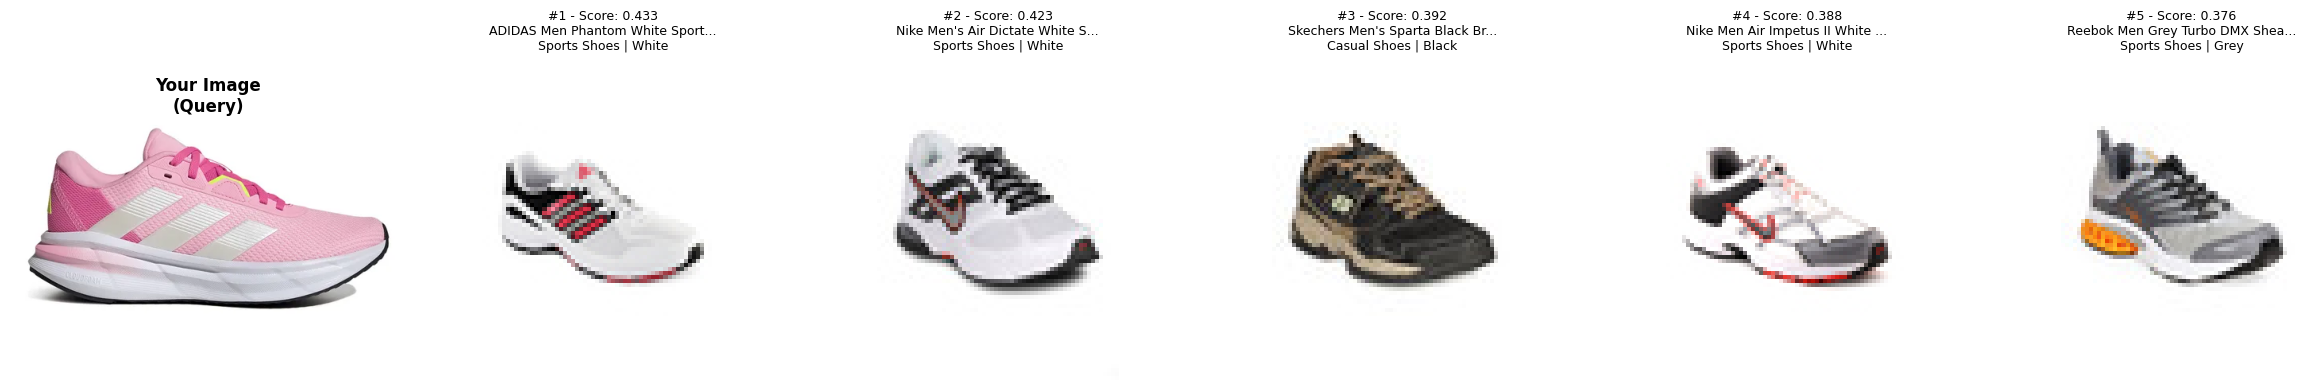

In [38]:
#results = find_similar_products("my_shirt.jpg", top_k=5)

results = find_similar_products("https://http2.mlstatic.com/D_605511-MLB84357623045_052025-O-tnis-adidas-galaxy-7-feminino-esportivo-corrida-caminhada.webp", top_k=5)

POSSIVEIS UTILIZACOES


USAGE EXAMPLES:
===============

1. Search from local file:
   ------------------------------------------------------------
   results = find_similar_products("path/to/your/image.jpg")
   
2. Search from URL:
   ------------------------------------------------------------
   results = find_similar_products(
       "https://example.com/shirt.jpg",
       top_k=10
   )
   
3. Search without visualization:
   ------------------------------------------------------------
   results = find_similar_products(
       "my_image.jpg",
       top_k=5,
       show_images=False
   )
   
4. Access result data:
   ------------------------------------------------------------
   results = find_similar_products("image.jpg")
   for item in results:
       print(f"Product: {item['product_name']}")
       print(f"Score: {item['similarity_score']:.4f}")
       print(f"Category: {item['category']}")
       # Access the PIL Image object:
       # item['image'].save(f"result_{item['rank']}.jpg")

5. Filter by category after search:
   ------------------------------------------------------------
   results = find_similar_products("image.jpg", top_k=20)
   shirts = [r for r in results if r['category'] == 'Shirts']
   women_items = [r for r in results if r['gender'] == 'Women']

""")

print("="*60)
print("TRY IT NOW!")
print("="*60)
print("""
# Example with a random product from dataset:
test_product = candidate_dataset[50]
test_image_obj = test_product['image']

# Save it temporarily to demonstrate file loading
test_image_obj.save("test_query.jpg")

# Now search for similar products
results = find_similar_products("test_query.jpg", top_k=5)
""")